In [3]:
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load the saved CSV file
df_loaded = pd.read_csv('./exp_results.csv', index_col=0)  # Ensure index is preserved if needed

# Deserialize the pickled columns
df_loaded['Confusion matrix'] = df_loaded['Confusion matrix'].apply(lambda x: pickle.loads(eval(x)))
df_loaded['F1 scores'] = df_loaded['F1 scores'].apply(lambda x: pickle.loads(eval(x))  if isinstance(x, str) else x)
df_loaded["IOU"] = df_loaded["IOU"].apply(lambda x: pickle.loads(eval(x)) if isinstance(x, str) else x)



df_loaded = df_loaded[df_loaded['DR Method'].isin(['PCA', 'FastICA', 'UMAP', 'AE1', 'AE2','PCA-Split', 'FastICA-Split', 'UMAP-Split'])]


# Check the loaded DataFrame
df_loaded.head()

,Experiment,Confusion matrix,Accuracy,F1 scores,Kappa,IOU,Dataset,DR Method,N Components,Model
0,Salinas_PCA_8_mou,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.285337,"[0.0, 0.9757838388988019, 1.0, 0.9977266986612...",0.947651,"[0.0, 0.9527127924340468, 1.0, 0.9954637096774...",Salinas,PCA,8,mou
1,Salinas_PCA_8_hamida,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",94.708936,"[0.0, 0.9757838388988019, 1.0, 0.9992414664981...",0.941174,"[0.0, 0.9527127924340468, 1.0, 0.9984840828701...",Salinas,PCA,8,hamida
2,Salinas_PCA_8_li,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.701011,"[0.0, 0.9757838388988019, 1.0, 0.9997470275739...",0.952256,"[0.0, 0.9527127924340468, 1.0, 0.9994941831057...",Salinas,PCA,8,li
3,Salinas_PCA_8_paoletti,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.536589,"[0.0, 0.9757838388988019, 1.0, 0.9929149797570...",0.950400,"[0.0, 0.9527127924340468, 1.0, 0.9859296482412...",Salinas,PCA,8,paoletti
4,Salinas_PCA_15_mou,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",88.488611,"[0.0, 0.9612202688728024, 0.9907914053116241, ...",0.872189,"[0.0, 0.925335988053758, 0.9817508595609628, 0...",Salinas,PCA,15,mou


# 1st hypothesis: greater number of components does not grant better classification performance

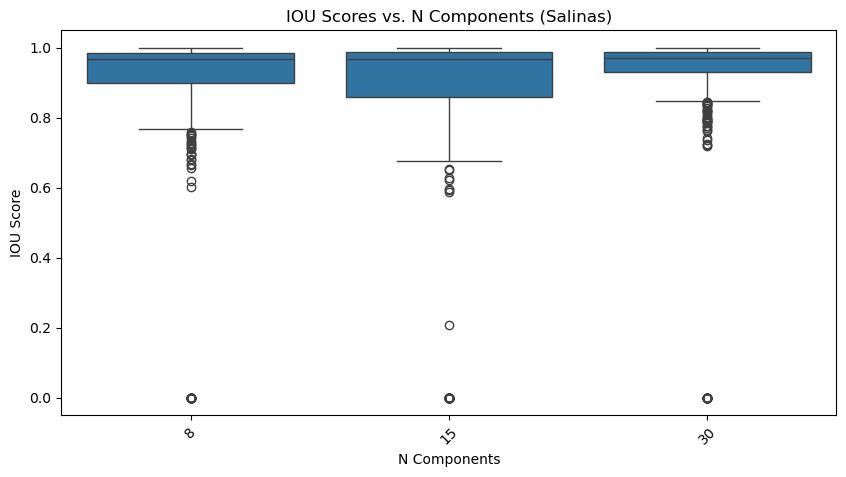

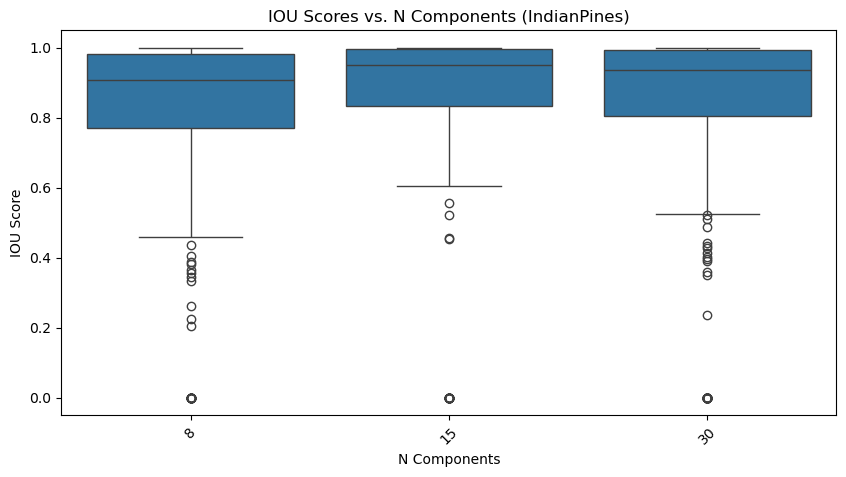

In [5]:


def plot_iou_vs_ncomponents(df, dataset_name):
    df_subset = df[df["Dataset"] == dataset_name]

    expanded_data = []
    for _, row in df_subset.iterrows():
        for iou in row["IOU"]:
            expanded_data.append({"N Components": row["N Components"], "IOU": iou})

    df_anova = pd.DataFrame(expanded_data)

    plt.figure(figsize=(10, 5))
    sns.boxplot(x="N Components", y="IOU", data=df_anova)
    plt.title(f"IOU Scores vs. N Components ({dataset_name})")
    plt.xlabel("N Components")
    plt.ylabel("IOU Score")
    plt.xticks(rotation=45)
    plt.show()

plot_iou_vs_ncomponents(df_loaded, "Salinas")
plot_iou_vs_ncomponents(df_loaded, "IndianPines")


In [6]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def analyze_n_components_effect(df):
    # Initialize a list to store the results
    results = []

    # Group by Dataset, DR Method, Model
    groups = df.groupby(["Dataset", "DR Method", "Model"])

    for (dataset, dr_method, model), group_df in groups:
        print(f"\n🔎 Analyzing: {dataset} - {dr_method} - {model}")

        # Expand IOU values for the analysis
        expanded_data = []
        for _, row in group_df.iterrows():
            for iou in row["IOU"]:  
                expanded_data.append({"N Components": row["N Components"], "IOU": iou})

        df_anova = pd.DataFrame(expanded_data)

        # Group IOU scores by N Components
        grouped_data = {n: group["IOU"].values for n, group in df_anova.groupby("N Components")}

        if len(grouped_data) < 3:
            print("  ❌ Not enough groups for ANOVA. Skipping.")
            continue

        # Perform ANOVA
        print(grouped_data)
        f_stat, p_value = stats.f_oneway(*grouped_data.values())
        print(f"  ✅ ANOVA results: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")

        # Record the result for ANOVA
        alpha = 0.05
        if p_value >= alpha:
            anova_result = "Fail to reject null hypothesis: More components do not significantly improve performance."
            trend = "No significant difference"
        else:
            anova_result = "Reject null hypothesis: More components significantly affect performance!"
            trend = "Significant difference detected"

        # Perform paired t-tests independently of ANOVA result
        p_values_t_tests = {}  # Initialize a dictionary for T-test p-values
        for comp_1, comp_2 in [(8, 15), (8, 30), (15, 30)]:
            if comp_1 in grouped_data and comp_2 in grouped_data:
                t_stat, p_val = stats.ttest_rel(grouped_data[comp_1], grouped_data[comp_2])
                p_values_t_tests[f"{comp_1} vs {comp_2}"] = p_val
                print(f"  🔹 Paired T-Test ({comp_1} vs {comp_2} components): T-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

                # Determine trend based on the paired t-test results
                if p_val < 0.05:
                    if np.mean(grouped_data[comp_2]) > np.mean(grouped_data[comp_1]):
                        trend_t_test = f"More components ({comp_2}) improve performance"
                    else:
                        trend_t_test = f"Fewer components ({comp_1}) improve performance"
                else:
                    trend_t_test = "No significant difference based on T-test"
                
                # Append T-test trend to the results
                results.append({
                    "Dataset": dataset,
                    "DR Method": dr_method,
                    "Model": model,
                    "T-Test Comparison": f"{comp_1} vs {comp_2}",
                    "T-Test P-value": p_val,
                    "Trend (T-Test)": trend_t_test
                })

        # Collect ANOVA results into the results list
        results.append({
            "Dataset": dataset,
            "DR Method": dr_method,
            "Model": model,
            "F-statistic (ANOVA)": f_stat,
            "P-value (ANOVA)": p_value,
            "ANOVA Result": anova_result,
            "Trend (ANOVA)": trend
        })

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("n_components_effect_results_with_anova_and_ttests.csv", index=False)

    # Print success message
    print("\n🔒 Results saved to 'n_components_effect_results_with_anova_and_ttests.csv'")

    return results_df
 
# Run the analysis
results_df = analyze_n_components_effect(df_loaded)



🔎 Analyzing: IndianPines - AE1 - hamida
{8: array([0.        , 0.52112676, 0.73100872, 0.71367061, 0.80478088,
       0.40606061, 0.84841363, 0.78571429, 0.9382716 , 0.8       ,
       0.80485528, 0.83001128, 0.59487179, 0.99512195, 0.81038961,
       0.45979899, 0.9893617 ]), 15: array([0.        , 0.86956522, 0.89217033, 0.85414236, 0.95934959,
       0.83464567, 0.93766578, 1.        , 0.98760331, 1.        ,
       0.90504451, 0.92277842, 0.9248366 , 0.98536585, 0.95011338,
       0.65721649, 1.        ]), 30: array([0.        , 0.95833333, 0.84974425, 0.8062201 , 0.94693878,
       0.75350701, 0.97319035, 1.        , 0.99790795, 1.        ,
       0.8964467 , 0.89211618, 0.82401316, 0.99514563, 0.89841499,
       0.64781491, 1.        ])}
  ✅ ANOVA results: F-statistic = 2.1370, p-value = 0.1291
  🔹 Paired T-Test (8 vs 15 components): T-statistic = -5.1874, p-value = 0.0001
  🔹 Paired T-Test (8 vs 30 components): T-statistic = -4.8984, p-value = 0.0002
  🔹 Paired T-Test (15 vs 30

In [7]:
results_df['Trend (T-Test)'].value_counts()

Trend (T-Test)
No significant difference based on T-test    96
More components (30) improve performance     45
More components (15) improve performance     27
Fewer components (8) improve performance     14
Fewer components (15) improve performance    10
Name: count, dtype: int64

# 2nd hypothesis - deeper architectures do not grant better performance

In [8]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def analyze_architecture_depth_effect(df):
    # Initialize a list to store the results
    results = []

    # Define groups for CNN and RNN architectures
    cnn_architectures = ['li', 'hamida']  # Shallow: Li, Deep: Hamida
    rnn_architectures = ['mou', 'paoletti']  # Shallow: Mou, Deep: Paoletti

    # Define the shallow and deep architectures mapping
    architecture_mapping = {
        "li": "Shallow",  # Li is shallow
        "hamida": "Deep", # Hamida is deep
        "mou": "Shallow", # Mou is shallow
        "paoletti": "Deep" # Paoletti is deep
    }

    # Filter data for CNNs and RNNs separately
    for architecture_group, architectures in [("CNNs", cnn_architectures), ("RNNs", rnn_architectures)]:
        print(f"\n🔎 Analyzing {architecture_group}: {architectures}")

        # Filter the DataFrame to only include the relevant architectures
        df_filtered = df[df["Model"].isin(architectures)]

        # Group by Dataset, DR Method, and Number of Components
        groups = df_filtered.groupby(["Dataset", "DR Method", "N Components"])

        for (dataset, dr_method, n_components), group_df in groups:
            print(f"\n🔎 Analyzing: {dataset} - {dr_method} - N Components: {n_components}")

            # Expand IOU values for the analysis
            expanded_data = []
            for _, row in group_df.iterrows():
                for iou in row["IOU"]:  
                    expanded_data.append({"Model": row["Model"], "IOU": iou})

            df_anova = pd.DataFrame(expanded_data)

            # Group IOU scores by Model (Shallow vs Deep)
            grouped_data = {model: group["IOU"].values for model, group in df_anova.groupby("Model")}

            if len(grouped_data) < 2:
                print("  ❌ Not enough groups for paired t-test. Skipping.")
                continue

            # Perform paired t-test only if we have two models
            if len(grouped_data) == 2:
                print(list(grouped_data.keys()))
                
                # Get the actual model names (for Shallow/Deep mapping)
                model_names = list(grouped_data.keys())
                shallow_model = model_names[0] if architecture_mapping[model_names[0]] == "Shallow" else model_names[1]
                deep_model = model_names[1] if shallow_model == model_names[0] else model_names[0]

                t_stat, p_val = stats.ttest_rel(grouped_data[shallow_model], grouped_data[deep_model])
                print(f"  🔹 Paired T-Test ({shallow_model} vs {deep_model} architecture): T-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

                # Get the correct trend labels for shallow and deep models
                shallow_label = architecture_mapping.get(shallow_model, "Unknown")
                deep_label = architecture_mapping.get(deep_model, "Unknown")

                # Determine trend based on the paired t-test results
                if p_val < 0.05:
                    if np.mean(grouped_data[deep_model]) > np.mean(grouped_data[shallow_model]):
                        trend_t_test = f"Deeper architecture ({deep_model}) improves performance"
                    else:
                        trend_t_test = f"Shallow architecture ({shallow_model}) improves performance"
                else:
                    trend_t_test = "No significant difference based on T-test"

                # Print the T-test trend
                print(f"  📈 T-Test Trend: {trend_t_test}")
                
                # Append T-test trend to the results
                results.append({
                    "Dataset": dataset,
                    "DR Method": dr_method,
                    "N Components": n_components,
                    "Architecture Group": architecture_group,
                    "T-Test Comparison": f"{shallow_model} vs {deep_model}",
                    "T-Test P-value": p_val,
                    "Trend (T-Test)": trend_t_test
                })

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("architecture_depth_effect_results_with_ttests_only.csv", index=False)

    # Print success message
    print("\n🔒 Results saved to 'architecture_depth_effect_results_with_ttests_only.csv'")

    return results_df

# Run the analysis
results_df = analyze_architecture_depth_effect(df_loaded)



🔎 Analyzing CNNs: ['li', 'hamida']

🔎 Analyzing: IndianPines - AE1 - N Components: 8
['hamida', 'li']
  🔹 Paired T-Test (li vs hamida architecture): T-statistic = 4.5356, p-value = 0.0003
  📈 T-Test Trend: Shallow architecture (li) improves performance

🔎 Analyzing: IndianPines - AE1 - N Components: 15
['hamida', 'li']
  🔹 Paired T-Test (li vs hamida architecture): T-statistic = 2.5690, p-value = 0.0206
  📈 T-Test Trend: Shallow architecture (li) improves performance

🔎 Analyzing: IndianPines - AE1 - N Components: 30
['hamida', 'li']
  🔹 Paired T-Test (li vs hamida architecture): T-statistic = -1.7907, p-value = 0.0923
  📈 T-Test Trend: No significant difference based on T-test

🔎 Analyzing: IndianPines - AE2 - N Components: 8
['hamida', 'li']
  🔹 Paired T-Test (li vs hamida architecture): T-statistic = 4.4473, p-value = 0.0004
  📈 T-Test Trend: Shallow architecture (li) improves performance

🔎 Analyzing: IndianPines - AE2 - N Components: 15
['hamida', 'li']
  🔹 Paired T-Test (li vs h

## 2nd Hypothesis (modified to group only by dataset)

In [16]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def analyze_architecture_depth_effect_by_dataset(df):
    results = []

    # Define groups for CNN and RNN architectures
    cnn_architectures = ['li', 'hamida']  # Shallow: Li, Deep: Hamida
    rnn_architectures = ['mou', 'paoletti']  # Shallow: Mou, Deep: Paoletti

    # Mapping from model name to architecture depth
    architecture_mapping = {
        "li": "Shallow",
        "hamida": "Deep",
        "mou": "Shallow",
        "paoletti": "Deep"
    }

    for architecture_group, models in [("CNNs", cnn_architectures), ("RNNs", rnn_architectures)]:
        print(f"\n🔍 Analyzing {architecture_group}: {models}")

        df_group = df[df["Model"].isin(models)]

        # Group only by Dataset
        for dataset, group_df in df_group.groupby("Dataset"):
            print(f"\n📊 Dataset: {dataset}")

            shallow_ious = []
            deep_ious = []

            for _, row in group_df.iterrows():
                if architecture_mapping[row["Model"]] == "Shallow":
                    shallow_ious.extend(row["IOU"])
                elif architecture_mapping[row["Model"]] == "Deep":
                    deep_ious.extend(row["IOU"])

            shallow_ious = np.array(shallow_ious)
            deep_ious = np.array(deep_ious)

            if len(shallow_ious) == 0 or len(deep_ious) == 0:
                print("  ❌ Not enough data for paired t-test. Skipping.")
                continue

            # Trim to same length for paired t-test
            min_len = min(len(shallow_ious), len(deep_ious))
            shallow_ious = shallow_ious[:min_len]
            deep_ious = deep_ious[:min_len]

            t_stat, p_val = stats.ttest_rel(shallow_ious, deep_ious)
            print(f"  🔹 T-Test: T-stat = {t_stat:.4f}, p = {p_val:.4f}")

            if p_val < 0.05:
                if np.mean(deep_ious) > np.mean(shallow_ious):
                    trend = f"Deeper architecture improves performance"
                else:
                    trend = f"Shallow architecture outperforms deeper one"
            else:
                trend = "No significant difference based on T-test"

            print(f"  📈 Trend: {trend}")

            results.append({
                "Dataset": dataset,
                "Architecture Group": architecture_group,
                "T-Test Comparison": f"Shallow vs Deep",
                "T-Test P-value": p_val,
                "Trend (T-Test)": trend
            })

    results_df = pd.DataFrame(results)
    results_df.to_csv("architecture_depth_effect_by_dataset.csv", index=False)

    print("\n🔒 Results saved to 'architecture_depth_effect_by_dataset.csv'")
    return results_df

# Run the analysis
results_df = analyze_architecture_depth_effect_by_dataset(df_loaded)



🔍 Analyzing CNNs: ['li', 'hamida']

📊 Dataset: IndianPines
  🔹 T-Test: T-stat = -4.3897, p = 0.0000
  📈 Trend: Deeper architecture improves performance

📊 Dataset: Salinas
  🔹 T-Test: T-stat = -2.9504, p = 0.0034
  📈 Trend: Deeper architecture improves performance

🔍 Analyzing RNNs: ['mou', 'paoletti']

📊 Dataset: IndianPines
  🔹 T-Test: T-stat = -4.2323, p = 0.0000
  📈 Trend: Deeper architecture improves performance

📊 Dataset: Salinas
  🔹 T-Test: T-stat = -2.3650, p = 0.0185
  📈 Trend: Deeper architecture improves performance

🔒 Results saved to 'architecture_depth_effect_by_dataset.csv'


# 3rd hypothesis - split methods are better for RNNs

In [9]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def analyze_architecture_depth_effect(df):
    # Initialize a list to store the results
    results = []


    # Define the shallow and deep architectures mapping
    method_mapping = {
        "PCA": "Original",  
        "FastICA": "Original",
        "UMAP": "Original",
        "PCA-Split": "Split",
        "FastICA-Split": "Split",
        "UMAP-Split": "Split",
    }

    # Filter data for each method separately and RNNs separately
    for method_group, methods in [("PCA", ['PCA', 'PCA-Split']), ("FastICA", ['FastICA', 'FastICA-Split']), ("UMAP", ['UMAP', 'UMAP-Split'])]:
        print(f"\n🔎 Analyzing {method_group}: {methods}")

        # Filter the DataFrame to only include the relevant methods
        df_filtered = df[df["DR Method"].isin(methods)]

        # Group by Dataset, DR Method, and Number of Components
        groups = df_filtered.groupby(["Dataset", "N Components", 'Model'])

        for (dataset, n_components, model), group_df in groups:
            print(f"\n🔎 Analyzing: {dataset} - {model} - N Components: {n_components}")

            # Expand IOU values for the analysis
            expanded_data = []
            for _, row in group_df.iterrows():
                for iou in row["IOU"]:  
                    expanded_data.append({"DR Method": row["DR Method"], "IOU": iou})

            df_anova = pd.DataFrame(expanded_data)

            # Group IOU scores by method (Original vs Split)
            grouped_data = {method: group["IOU"].values for method, group in df_anova.groupby("DR Method")}

            if len(grouped_data) < 2:
                print("  ❌ Not enough groups for paired t-test. Skipping.")
                continue

            # Perform paired t-test only if we have two models
            if len(grouped_data) == 2:
                print(list(grouped_data.keys()))
                
                # Get the actual model names (for Original/Deep mapping)
                methods_names = list(grouped_data.keys())
                original_method = methods_names[0] if method_mapping[methods_names[0]] == "Original" else methods_names[1]
                split_method = methods_names[1] if original_method == methods_names[0] else methods_names[0]

                t_stat, p_val = stats.ttest_rel(grouped_data[original_method], grouped_data[split_method])
                print(f"  🔹 Paired T-Test ({original_method} vs {split_method} method): T-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

        

                # Determine trend based on the paired t-test results
                if p_val < 0.05:
                    if np.mean(grouped_data[split_method]) > np.mean(grouped_data[original_method]):
                        trend_t_test = f"Split method ({split_method}) improves performance"
                    else:
                        trend_t_test = f"Original method ({original_method}) improves performance"
                else:
                    trend_t_test = "No significant difference based on T-test"

                # Print the T-test trend
                print(f"  📈 T-Test Trend: {trend_t_test}")
                
                # Append T-test trend to the results
                results.append({
                    "Dataset": dataset,
                    "Model": model,
                    "N Components": n_components,
                    "DR Method Group": method_group,
                    "T-Test Comparison": f"{original_method} vs {split_method}",
                    "T-Test P-value": p_val,
                    "Trend (T-Test)": trend_t_test
                })

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv("split_effect_results_with_ttests_only.csv", index=False)

    # Print success message
    print("\n🔒 Results saved to 'split_effect_results_with_ttests_only.csv'")

    return results_df

# Run the analysis
results_df = analyze_architecture_depth_effect(df_loaded)



🔎 Analyzing PCA: ['PCA', 'PCA-Split']

🔎 Analyzing: IndianPines - hamida - N Components: 8
['PCA', 'PCA-Split']
  🔹 Paired T-Test (PCA vs PCA-Split method): T-statistic = 3.6517, p-value = 0.0022
  📈 T-Test Trend: Original method (PCA) improves performance

🔎 Analyzing: IndianPines - li - N Components: 8
['PCA', 'PCA-Split']
  🔹 Paired T-Test (PCA vs PCA-Split method): T-statistic = 2.7447, p-value = 0.0144
  📈 T-Test Trend: Original method (PCA) improves performance

🔎 Analyzing: IndianPines - mou - N Components: 8
['PCA', 'PCA-Split']
  🔹 Paired T-Test (PCA vs PCA-Split method): T-statistic = 1.4338, p-value = 0.1709
  📈 T-Test Trend: No significant difference based on T-test

🔎 Analyzing: IndianPines - paoletti - N Components: 8
['PCA', 'PCA-Split']
  🔹 Paired T-Test (PCA vs PCA-Split method): T-statistic = 0.1520, p-value = 0.8811
  📈 T-Test Trend: No significant difference based on T-test

🔎 Analyzing: IndianPines - hamida - N Components: 15
['PCA', 'PCA-Split']
  🔹 Paired T-Test

## Modified tests for 3rd Hypothesis

In [12]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def analyze_split_method_effect(df):
    # Initialize a list to store the results
    results = []

    # Define model groups
    model_groups = {
        "RNNs": ['mou', 'paoletti'],
        "CNNs": ['li', 'hamida']
    }

    # Define original and split method pairs
    method_mapping = {
        "PCA": "PCA-Split",
        "FastICA": "FastICA-Split",
        "UMAP": "UMAP-Split"
    }

    for group_name, models in model_groups.items():
        print(f"\n🔍 Analyzing {group_name} models: {models}")
        
        df_models = df[df["Model"].isin(models)]

        for original_method, split_method in method_mapping.items():
            print(f"\n🔎 Method pair: {original_method} vs {split_method}")

            df_subset = df_models[df_models["DR Method"].isin([original_method, split_method])]

            # Group only by Dataset
            dataset_groups = df_subset.groupby("Dataset")

            for dataset, group_df in dataset_groups:
                print(f"\n📊 Dataset: {dataset}")

                original_ious = []
                split_ious = []

                for _, row in group_df.iterrows():
                    if row["DR Method"] == original_method:
                        original_ious.extend(row["IOU"])
                    elif row["DR Method"] == split_method:
                        split_ious.extend(row["IOU"])

                original_ious = np.array(original_ious)
                split_ious = np.array(split_ious)

                if len(original_ious) == 0 or len(split_ious) == 0:
                    print("  ❌ Not enough data for paired t-test. Skipping.")
                    continue

                min_len = min(len(original_ious), len(split_ious))
                original_ious = original_ious[:min_len]
                split_ious = split_ious[:min_len]

                t_stat, p_val = stats.ttest_rel(original_ious, split_ious)
                print(f"  🔹 T-Test: T-stat = {t_stat:.4f}, p = {p_val:.4f}")

                if p_val < 0.05:
                    if np.mean(split_ious) > np.mean(original_ious):
                        trend = f"Split method ({split_method}) improves performance"
                    else:
                        trend = f"Original method ({original_method}) performs better"
                else:
                    trend = "No significant difference based on T-test"

                print(f"  📈 Trend: {trend}")

                results.append({
                    "Model Group": group_name,
                    "Dataset": dataset,
                    "DR Method Comparison": f"{original_method} vs {split_method}",
                    "T-Test P-value": p_val,
                    "Trend (T-Test)": trend
                })

    results_df = pd.DataFrame(results)
    results_df.to_csv("split_effect_results_rnn_cnn.csv", index=False)

    print("\n🔒 Results saved to 'split_effect_results_rnn_cnn.csv'")
    return results_df

# Run the analysis
results_df = analyze_split_method_effect(df_loaded)



🔍 Analyzing RNNs models: ['mou', 'paoletti']

🔎 Method pair: PCA vs PCA-Split

📊 Dataset: IndianPines
  🔹 T-Test: T-stat = -1.3409, p = 0.1830
  📈 Trend: No significant difference based on T-test

📊 Dataset: Salinas
  🔹 T-Test: T-stat = -4.5746, p = 0.0000
  📈 Trend: Split method (PCA-Split) improves performance

🔎 Method pair: FastICA vs FastICA-Split

📊 Dataset: IndianPines
  🔹 T-Test: T-stat = -0.4542, p = 0.6506
  📈 Trend: No significant difference based on T-test

📊 Dataset: Salinas
  🔹 T-Test: T-stat = 6.6538, p = 0.0000
  📈 Trend: Original method (FastICA) performs better

🔎 Method pair: UMAP vs UMAP-Split

📊 Dataset: IndianPines
  🔹 T-Test: T-stat = -5.7008, p = 0.0000
  📈 Trend: Split method (UMAP-Split) improves performance

📊 Dataset: Salinas
  🔹 T-Test: T-stat = -0.0835, p = 0.9336
  📈 Trend: No significant difference based on T-test

🔍 Analyzing CNNs models: ['li', 'hamida']

🔎 Method pair: PCA vs PCA-Split

📊 Dataset: IndianPines
  🔹 T-Test: T-stat = -2.3289, p = 0.0219
